<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/P7%20-%20D%C3%A9veloppez%20une%20preuve%20de%20concept/D%C3%A9veloppez_une_preuve_de_concept_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Je vais essayer ici d'utiliser un modèle ViT pré-entrainé par Google, mis à disposition sur le site HuggingFace : https://huggingface.co/google/vit-base-patch16-224-in21k

In [2]:
pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 7.4 MB/s 
     |████████████████████████████████| 895 kB 76.6 MB/s 
     |████████████████████████████████| 6.8 MB 75.9 MB/s 
     |████████████████████████████████| 61 kB 565 kB/s 


In [3]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
from PIL import Image
import requests
from google.colab import drive
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
    Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation,\
    RandomContrast, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanAbsoluteError, \
  MeanAbsolutePercentageError
!pip install tensorflow-addons
import tensorflow_addons as tfa
from scipy.io import loadmat
from tqdm import tqdm

     |████████████████████████████████| 1.1 MB 8.4 MB/s 


In [4]:
google_vit_model = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(google_vit_model)
model = ViTForImageClassification.from_pretrained(google_vit_model)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]


je vais tester les prédictions avec des images de mon jeu de données "Stanford Cars dataset"

In [5]:
from google.colab import drive
drive._mount('/content/drive', force_remount=False)
#drive.mount("/content/gdrive") #, force_remount=False)
os.chdir("/content/drive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Mounted at /content/drive
Répertoire de travail courant : /content/drive/MyDrive/Colab Notebooks


In [6]:
IDX_CLASS_ID = 5  # index de l'id de classe dans le .mat
IDX_FILENAME = 0  # index du nom de fichier dans le .mat
IMAGES_DIR = 'car_ims'  # répertoire du jeu de données brut
IMAGES_DIR_TREE = 'cars_ims_tree'  # répertoire arborescent généré
TEST_DIR_TREE = 'cars_test_tree'  # répertoire de test arborescent généré
cars_meta = loadmat('cars_meta.mat')['class_names'][0]
cars_annos = loadmat('cars_annos.mat')['annotations'][0]

Je range les images dans une arborescence de répertoires par classe.

In [7]:
import shutil

if not os.path.exists(IMAGES_DIR_TREE):
    os.makedirs(IMAGES_DIR_TREE)
    for car in tqdm(cars_annos):
        class_id = int(car[IDX_CLASS_ID][0][0])
        class_name = cars_meta[class_id - 1][0]
        filename = car[IDX_FILENAME][0]
        class_dir = os.path.join(IMAGES_DIR_TREE, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        dst_file = os.path.join(class_dir, filename.split('/')[1])
        if not os.path.exists(dst_file):
          shutil.copyfile(filename, dst_file)
      

In [21]:
print(cars_meta[173][0])

Ram C/V Cargo Van Minivan 2012


Je déplace 100 images de 100 modèles différents pour tests

In [7]:
if not os.path.exists(TEST_DIR_TREE):
    os.makedirs(TEST_DIR_TREE)
    i = 0
    for car_model in os.listdir(IMAGES_DIR_TREE):
        src_dir = os.path.join(IMAGES_DIR_TREE, car_model)
        filename = os.listdir(src_dir)[0]
        src = os.path.join(src_dir, filename)
        dst_dir = os.path.join(TEST_DIR_TREE, car_model)
        os.makedirs(dst_dir)
        dst = os.path.join(dst_dir, filename)
        shutil.move(src, dst)
        i += 1
        if i >= 100:
          break

In [29]:
# vérification compte images
nb_images = 0
counts = []
for car_model in os.listdir(IMAGES_DIR_TREE):
    car_model_dir = os.path.join(IMAGES_DIR_TREE, car_model)
    nb_car_model = len(os.listdir(car_model_dir))
    print("Nb images pour", car_model, ":", nb_car_model)
    nb_images += nb_car_model
    counts.append(nb_car_model)
print("Total d'images :", nb_images)

Nb images pour AM General Hummer SUV 2000 : 88
Nb images pour Acura RL Sedan 2012 : 63
Nb images pour Acura TL Sedan 2012 : 85
Nb images pour Acura TL Type-S 2008 : 83
Nb images pour Acura TSX Sedan 2012 : 80
Nb images pour Acura Integra Type R 2001 : 88
Nb images pour Acura ZDX Hatchback 2012 : 77
Nb images pour Aston Martin V8 Vantage Convertible 2012 : 89
Nb images pour Aston Martin V8 Vantage Coupe 2012 : 81
Nb images pour Aston Martin Virage Convertible 2012 : 65
Nb images pour Aston Martin Virage Coupe 2012 : 75
Nb images pour Audi RS 4 Convertible 2008 : 72
Nb images pour Audi A5 Coupe 2012 : 81
Nb images pour Audi TTS Coupe 2012 : 84
Nb images pour Audi R8 Coupe 2012 : 85
Nb images pour Audi V8 Sedan 1994 : 86
Nb images pour Audi 100 Sedan 1994 : 80
Nb images pour Audi 100 Wagon 1994 : 84
Nb images pour Audi TT Hatchback 2011 : 80
Nb images pour Audi S6 Sedan 2011 : 91
Nb images pour Audi S5 Convertible 2012 : 83
Nb images pour Audi S5 Coupe 2012 : 84
Nb images pour Audi S4 Sed

In [35]:
counts.sort()
print("Modèles les moins représentés :", counts[:10])
counts.sort(reverse=True)
print("Modèles les plus représentés :", counts[:10])

Modèles les moins représentés : [48, 50, 54, 58, 58, 61, 63, 64, 65, 65]
Modèles les plus représentés : [136, 96, 96, 95, 93, 92, 92, 92, 92, 91]


Pour équilibrer, je déplace les images en nombre > 64

In [42]:
NB_MAX = 64
for car_model in os.listdir(IMAGES_DIR_TREE):
    src_dir = os.path.join(IMAGES_DIR_TREE, car_model)
    nb_car_model = len(os.listdir(car_model_dir))
    if nb_car_model > NB_MAX:
      for filename in os.listdir(src_dir)[NB_MAX:]:
        src = os.path.join(src_dir, filename)
        dst_dir = os.path.join(TEST_DIR_TREE, car_model)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        dst = os.path.join(dst_dir, filename)
        shutil.move(src, dst)

In [23]:
try:
    import hugsvision
except:
    !pip install -q hugsvision
    import hugsvision
    
print(hugsvision.__version__)

     |████████████████████████████████| 376 kB 10.8 MB/s 
     |████████████████████████████████| 526 kB 74.1 MB/s 
     |████████████████████████████████| 332 kB 78.0 MB/s 
     |████████████████████████████████| 829 kB 67.4 MB/s 
     |████████████████████████████████| 132 kB 90.2 MB/s 
     |████████████████████████████████| 1.1 MB 74.7 MB/s 
     |████████████████████████████████| 160 kB 90.3 MB/s 
     |████████████████████████████████| 271 kB 89.2 MB/s 
     |████████████████████████████████| 192 kB 76.3 MB/s 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


0.75.3


In [44]:
from hugsvision.dataio.VisionDataset import VisionDataset

train, test, id2label, label2id = VisionDataset.fromImageFolder(
	IMAGES_DIR_TREE,
	test_ratio   = 0.2,
	balanced     = False, # avec True, on tombe à 9408 images utilisées (min = 48)
	augmentation = True
)

Split Datasets...
train_ds:  9990
+---------+----------------------------+---------------------------+---------------------+---------------------+----------------------+----------------------+--------------------------+------------------------------------------+------------------------------------+--------------------------------------+--------------------------------+---------------------+---------------------+--------------------+--------------------+----------------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+------------------------+-----------------------+---------------------+--------------------+-------------------------------+-------------------------+-------------------------+-------------------------+-------------------------------+-------------------------------+-------------------+-------------------+-------------------------+-----------------+-----------------+-----------------+-----------------

In [45]:
len(label2id)

196

In [46]:
from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
google_vit_model = 'google/vit-base-patch16-224-in21k'

model = ViTForImageClassification.from_pretrained(
    google_vit_model,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

feature_extractor = ViTFeatureExtractor.from_pretrained(
    google_vit_model
)

trainer = VisionClassifierTrainer(
    model_name="CarsModel",
    train=train,
    test=test,
    output_dir="./out/",
    max_epochs=60,
    batch_size=32,
    lr=2e-5,
    fp16=True,
    model=model,
    feature_extractor=feature_extractor
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'0': 'AM General Hummer SUV 2000', '1': 'Acura Integra Type R 2001', '2': 'Acura RL Sedan 2012', '3': 'Acura TL Sedan 2012', '4': 'Acura TL Type-S 2008', '5': 'Acura TSX Sedan 2012', '6': 'Acura ZDX Hatchback 2012', '7': 'Aston Martin V8 Vantage Convertible 2012', '8': 'Aston Martin V8 Vantage Coupe 2012', '9': 'Aston Martin Virage Convertible 2012', '10': 'Aston Martin Virage Coupe 2012', '11': 'Audi 100 Sedan 1994', '12': 'Audi 100 Wagon 1994', '13': 'Audi A5 Coupe 2012', '14': 'Audi R8 Coupe 2012', '15': 'Audi RS 4 Convertible 2008', '16': 'Audi S4 Sedan 2007', '17': 'Audi S4 Sedan 2012', '18': 'Audi S5 Convertible 2012', '19': 'Audi S5 Coupe 2012', '20': 'Audi S6 Sedan 2011', '21': 'Audi TT Hatchback 2011', '22': 'Audi TT RS Coupe 2012', '23': 'Audi TTS Coupe 2012', '24': 'Audi V8 Sedan 1994', '25': 'BMW 1 Series Convertible 2012', '26': 'BMW 1 Series Coupe 2012', '27': 'BMW 3 Series Sedan 2012', '28': 'BMW 3 Series Wagon 2012', '29': 'BMW 6 Series Convertible 2007', '30': 'BMW Ac

Using amp half precision backend
***** Running training *****
  Num examples = 9990
  Num Epochs = 60
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 18780


Trainer builded!
Start Training!


Epoch,Training Loss,Validation Loss
1,No log,4.964999
2,5.019100,4.637311
3,5.019100,4.347899
4,4.435500,4.069889
5,3.877000,3.796823
6,3.877000,3.540246
7,3.316500,3.275804
8,2.756200,3.023913
9,2.756200,2.786787
10,2.188700,2.544381


***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** Running Evaluation *****
  Num examples = 2498
  Batch size = 32
***** 

Model saved at: ./out/CARSMODEL/60_2022-01-03-16-20-19


In [47]:
hyp, ref = trainer.evaluate_f1_score()

100%|██████████| 2498/2498 [01:21<00:00, 30.72it/s]

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     1.0000    0.8571    0.9231        14
                             Acura Integra Type R 2001     0.7000    0.6364    0.6667        11
                                   Acura RL Sedan 2012     0.5000    0.4000    0.4444         5
                                   Acura TL Sedan 2012     0.8750    0.7778    0.8235         9
                                  Acura TL Type-S 2008     0.8000    0.5000    0.6154        16
                                  Acura TSX Sedan 2012     0.7143    0.9091    0.8000        11
                              Acura ZDX Hatchback 2012     0.7778    0.7000    0.7368        10
              Aston Martin V8 Vantage Convertible 2012     0.7143    0.5882    0.6452        17
                    Aston Martin V8 Vantage Coupe 2012     0.3889    0.8750    0.5385         8
                  Aston Martin Virage C

Ici je copie le fichier config.json en preprocessor_config.json dans le répertoire du modèle ("path" ci-dessous)

Model loaded!
Predicted class: Audi TT Hatchback 2011


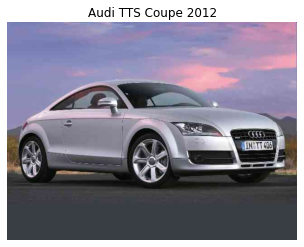

In [9]:
from hugsvision.inference.VisionClassifierInference import VisionClassifierInference
from shutil import copyfile
import matplotlib.pyplot as plt
%matplotlib inline

path = "/content/drive/MyDrive/Colab Notebooks/out/CARSMODEL/60_2022-01-03-16-20-19/model/"
src = os.path.join(path, 'config.json')
dst = os.path.join(path, 'preprocessor_config.json')
copyfile(src, dst)

class_name = 'Audi TTS Coupe 2012'
class_dir = os.path.join(IMAGES_DIR_TREE, class_name)
image_name = os.listdir(class_dir)[0]
image_path = os.path.join(class_dir, image_name)
image = Image.open(image_path)
plt.title(class_name)
plt.imshow(image)
plt.axis("off")

classifier = VisionClassifierInference(
    feature_extractor = ViTFeatureExtractor.from_pretrained(path),
    model = ViTForImageClassification.from_pretrained(path),
)

label = classifier.predict(img_path=image_path)
print("Predicted class:", label)

ça fonctionne ! Je teste sur plusieurs images que mon modèle n'a jamais vu :

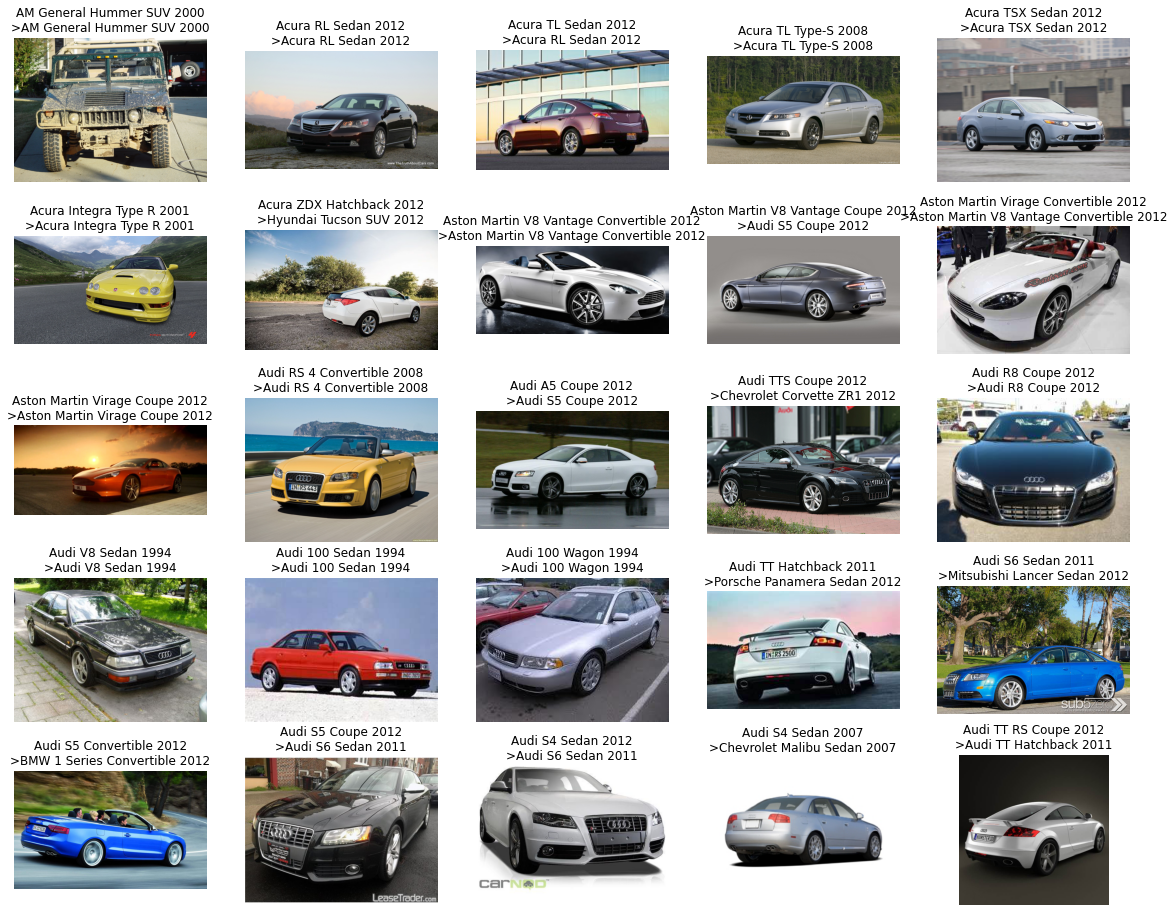

In [10]:
plt.figure(figsize=(20, 16))
i = 1
for sub_dir in os.listdir(TEST_DIR_TREE)[:25]:
    sub_dir_images = os.listdir(os.path.join(TEST_DIR_TREE, sub_dir))
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 25 and j == 0:
            img_path = os.path.join(TEST_DIR_TREE, sub_dir, sub_dir_image)
            img = Image.open(img_path)
            plt.subplot(5, 5, i)
            plt.axis('off')
            prediction = classifier.predict(img_path=img_path)
            plt.title(sub_dir + '\n>' + prediction)
            plt.imshow(img)
            i = i + 1
            j = j + 1
plt.show()

Il donne la bonne réponse 12 fois sur 25 ! C'est plutôt moyen, mais bien mieux que mon modèle "from scratch".

La faible précision vient principalement du petit nombre d'images par classe et du grand nombre de classes.

Je vais réduire le nombre de classes et conserver uniquement les 10 classes comportant le plus d'images.

In [21]:
counts = {}
for car in cars_annos:
    class_id = int(car[IDX_CLASS_ID][0][0])
    if class_id in counts.keys():
        counts[class_id] += 1
    else:
        counts[class_id] = 1

sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1]))
top_classes_ids = list(sorted_counts.keys())[-10:]
print(top_classes_ids)

[98, 171, 182, 191, 56, 144, 167, 161, 79, 119]


In [22]:
IMAGES_DIR_10 = "cars_ims_10"

if not os.path.exists(IMAGES_DIR_10):
    os.makedirs(IMAGES_DIR_10)
    for car in cars_annos:
        class_id = int(car[IDX_CLASS_ID][0][0])
        if class_id in top_classes_ids:
            class_name = cars_meta[class_id - 1][0].replace('/', '')
            filename = car[IDX_FILENAME][0]
            class_dir = os.path.join(IMAGES_DIR_10, class_name)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            dst_file = os.path.join(class_dir, filename.split('/')[1])
            if not os.path.exists(dst_file):
              shutil.copyfile(filename, dst_file)

In [24]:
from hugsvision.dataio.VisionDataset import VisionDataset

train, test, id2label, label2id = VisionDataset.fromImageFolder(
	IMAGES_DIR_10,
	test_ratio   = 0.2,
	balanced     = True,
	augmentation = True
)

Split Datasets...
Balance train dataset...
The less represented label in train as 92 occurrences
Size of train after balancing is 920
train_ds:  736
+---------+-----------------------------+-------------------------+----------------------------+---------------------+--------------------+------------------------------------------+------------------------------+-------------------------+---------------------------+--------------------------------+-------+
| Dataset | Chevrolet Corvette ZR1 2012 | Chrysler 300 SRT-8 2010 | Eagle Talon Hatchback 1998 | GMC Savana Van 2012 | Jaguar XK XKR 2012 | Mercedes-Benz 300-Class Convertible 1993 | Mitsubishi Lancer Sedan 2012 | Nissan 240SX Coupe 1998 | Suzuki Kizashi Sedan 2012 | Volkswagen Golf Hatchback 1991 | Total |
+---------+-----------------------------+-------------------------+----------------------------+---------------------+--------------------+------------------------------------------+------------------------------+--------------------

In [25]:
len(label2id)

10

In [27]:
from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
google_vit_model = 'google/vit-base-patch16-224-in21k'

model = ViTForImageClassification.from_pretrained(
    google_vit_model,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

feature_extractor = ViTFeatureExtractor.from_pretrained(
    google_vit_model
)

trainer = VisionClassifierTrainer(
    model_name="CarsModel",
    train=train,
    test=test,
    output_dir="./out/",
    max_epochs=100,
    batch_size=32,
    lr=2e-5,
    fp16=True,
    model=model,
    feature_extractor=feature_extractor
)

loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.92995a56e2eabab0c686015c4ad8275b4f9cbd858ed228f6a08936f2c31667e7
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Chevrolet Corvette ZR1 2012",
    "1": "Chrysler 300 SRT-8 2010",
    "2": "Eagle Talon Hatchback 1998",
    "3": "GMC Savana Van 2012",
    "4": "Jaguar XK XKR 2012",
    "5": "Mercedes-Benz 300-Class Convertible 1993",
    "6": "Mitsubishi Lancer Sedan 2012",
    "7": "Nissan 240SX Coupe 1998",
    "8": "Suzuki Kizashi Sedan 2012",
    "9": "Volkswagen Golf Hatchback 1991"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermedia

{'0': 'Chevrolet Corvette ZR1 2012', '1': 'Chrysler 300 SRT-8 2010', '2': 'Eagle Talon Hatchback 1998', '3': 'GMC Savana Van 2012', '4': 'Jaguar XK XKR 2012', '5': 'Mercedes-Benz 300-Class Convertible 1993', '6': 'Mitsubishi Lancer Sedan 2012', '7': 'Nissan 240SX Coupe 1998', '8': 'Suzuki Kizashi Sedan 2012', '9': 'Volkswagen Golf Hatchback 1991'}
{'Chevrolet Corvette ZR1 2012': '0', 'Chrysler 300 SRT-8 2010': '1', 'Eagle Talon Hatchback 1998': '2', 'GMC Savana Van 2012': '3', 'Jaguar XK XKR 2012': '4', 'Mercedes-Benz 300-Class Convertible 1993': '5', 'Mitsubishi Lancer Sedan 2012': '6', 'Nissan 240SX Coupe 1998': '7', 'Suzuki Kizashi Sedan 2012': '8', 'Volkswagen Golf Hatchback 1991': '9'}
Trainer builded!
Start Training!


Epoch,Training Loss,Validation Loss
1,No log,2.183153
2,No log,2.018279
3,No log,1.860001
4,No log,1.707318
5,No log,1.553748
6,No log,1.417077
7,No log,1.283080
8,No log,1.162477
9,No log,1.043627
10,No log,0.944374


***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evaluation *****
  Num examples = 184
  Batch size = 32
***** Running Evalua

Model saved at: ./out/CARSMODEL/100_2022-01-04-10-06-47


In [28]:
hyp, ref = trainer.evaluate_f1_score()

100%|██████████| 184/184 [00:04<00:00, 40.26it/s]

                                          precision    recall  f1-score   support

             Chevrolet Corvette ZR1 2012     0.9524    0.9524    0.9524        21
                 Chrysler 300 SRT-8 2010     1.0000    0.9000    0.9474        20
              Eagle Talon Hatchback 1998     0.8889    0.8000    0.8421        20
                     GMC Savana Van 2012     1.0000    1.0000    1.0000        16
                      Jaguar XK XKR 2012     0.8333    0.8824    0.8571        17
Mercedes-Benz 300-Class Convertible 1993     0.8947    0.9444    0.9189        18
            Mitsubishi Lancer Sedan 2012     0.7222    0.9286    0.8125        14
                 Nissan 240SX Coupe 1998     0.9500    0.8261    0.8837        23
               Suzuki Kizashi Sedan 2012     0.8750    0.8750    0.8750        16
          Volkswagen Golf Hatchback 1991     0.9500    1.0000    0.9744        19

                                accuracy                         0.9076       184
              

On obtient un F1-score de 90% !

loading feature extractor configuration file ./out/CARSMODEL/100_2022-01-04-10-06-47/model/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "_processor_class": null,
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Chevrolet Corvette ZR1 2012",
    "1": "Chrysler 300 SRT-8 2010",
    "2": "Eagle Talon Hatchback 1998",
    "3": "GMC Savana Van 2012",
    "4": "Jaguar XK XKR 2012",
    "5": "Mercedes-Benz 300-Class Convertible 1993",
    "6": "Mitsubishi Lancer Sedan 2012",
    "7": "Nissan 240SX Coupe 1998",
    "8": "Suzuki Kizashi Sedan 2012",
    "9": "Volkswagen Golf Hatchback 1991"
  },
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_size": 224,
  "image_std

Model loaded!
Predicted class: Chevrolet Corvette ZR1 2012


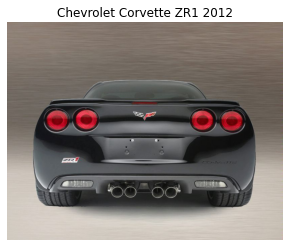

In [30]:
from hugsvision.inference.VisionClassifierInference import VisionClassifierInference
from shutil import copyfile
import matplotlib.pyplot as plt
%matplotlib inline

path = "./out/CARSMODEL/100_2022-01-04-10-06-47/model/"
src = os.path.join(path, 'config.json')
dst = os.path.join(path, 'preprocessor_config.json')
copyfile(src, dst)

class_name = 'Chevrolet Corvette ZR1 2012'
class_dir = os.path.join(IMAGES_DIR_10, class_name)
image_name = os.listdir(class_dir)[0]
image_path = os.path.join(class_dir, image_name)
image = Image.open(image_path)
plt.title(class_name)
plt.imshow(image)
plt.axis("off")

classifier = VisionClassifierInference(
    feature_extractor = ViTFeatureExtractor.from_pretrained(path),
    model = ViTForImageClassification.from_pretrained(path),
)

label = classifier.predict(img_path=image_path)
print("Predicted class:", label)

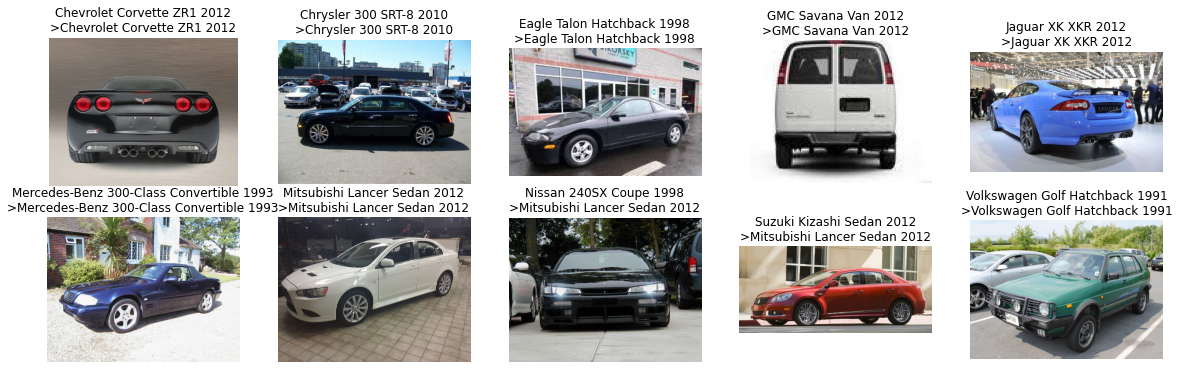

In [37]:
plt.figure(figsize=(20, 6))
i = 1
deja_vues = []
for car in cars_annos:
    class_id = int(car[IDX_CLASS_ID][0][0])
    if class_id in top_classes_ids and class_id not in deja_vues:
        deja_vues.append(class_id)
        class_name = cars_meta[class_id - 1][0].replace('/', '')
        sub_dir_images = os.listdir(os.path.join(TEST_DIR_TREE, class_name))
        img_path = os.path.join(TEST_DIR_TREE, class_name, sub_dir_images[0])
        img = Image.open(img_path)
        plt.subplot(2, 5, i)
        plt.axis('off')
        prediction = classifier.predict(img_path=img_path)
        plt.title(class_name + '\n>' + prediction)
        plt.imshow(img)
        i = i + 1
plt.show()

80% de réussite sur mon jeu de test ! C'est beaucoup mieux qu'avec les 196 classes.